# 2024/03/21 과제

[전제조건] 
- 알파벳 26개를 사용하는 언어를 식별할 수 있다.
- 언어마다 사용하는 알파벳 빈도는 다르다

[모델]
- 알파벳 입력 시 해당 언어 출력

[파일]
- test : en 4개 / fr 4개 / id 4개 / tl 4개
- train : en 10개 / fr 10개 / id 10개 / tl 10개

-> 데이터의 개수가 적으니 머신러닝이 적절함

## 1. 모듈 로딩 

In [37]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch # torch 기본 모듈로 텐서 기본 함수들 
import torch.nn as nn # linear Regression 기능의 클래스 Linear
import torch.nn.functional as F # 손실함수를 위함
import torch.optim as optim # 최적화를 위함

import os

from sklearn.preprocessing import OneHotEncoder
ohEncoder = OneHotEncoder(sparse_output=False)

## 2. 데이터 준비
1. 파일을 찾아간다. 
2. 파일명 split("-")[0] -> label
3. 리스트로 count하자 -> isalpha 사용
4. 알파벳...?빈도...?를 count
5. 그럼 데이터가...40개에 feature가 26인..?에

In [52]:
path = "../data/lang_data/"

def count_alphas(name):
    '''
    name : test or train
    :return: lable, feature
    '''
    label = []
    feature_array = np.zeros((1, 26)) # dummy -> 나중에 제거 해주기
    file_list = os.listdir(path = "../data/lang_data/"+name)
    for file in file_list:
        temp_array = list(np.zeros(26))

        with open("../data/lang_data/"+name+"/"+file,"r", encoding="utf-8") as f:
            chars = f.read() # 통 str
            chars = chars.lower()
        
        for c in chars: # 한 글자씩 읽기
            if c.isalpha(): # A~Z, a~z
                if ord(c) <= 122:
                    temp_array[ord(c)-97] += 1 # 소문자로 변환
        
        temp_array = list(temp_array/sum(temp_array)) # 전처리 정규화
        label.append(file.split("-")[0])
        
        feature_array = np.append(feature_array, [temp_array], axis = 0)
        
    feature_array = feature_array[1:, :]# dummy 행 제거
    return feature_array, label

## train data 불러오기

In [54]:
x_train, y_train = count_alphas("train")
x_train = pd.DataFrame(x_train)
x_train, y_train

(          0         1         2         3         4         5         6   \
 0   0.075952  0.012840  0.045702  0.046137  0.105332  0.015669  0.019151   
 1   0.096747  0.012406  0.044621  0.033257  0.105817  0.021268  0.015951   
 2   0.084178  0.019912  0.030404  0.038870  0.136998  0.017408  0.031239   
 3   0.071646  0.012172  0.045643  0.032642  0.120055  0.014661  0.025173   
 4   0.072210  0.027715  0.029977  0.039593  0.121041  0.016780  0.023567   
 5   0.073806  0.020368  0.031099  0.039641  0.141261  0.020368  0.020368   
 6   0.081006  0.013555  0.035795  0.034010  0.123701  0.019075  0.018994   
 7   0.083812  0.016864  0.043478  0.040493  0.122686  0.023311  0.019532   
 8   0.089447  0.015744  0.029711  0.041249  0.116504  0.020782  0.015496   
 9   0.082587  0.013215  0.032848  0.038085  0.123968  0.022142  0.016847   
 10  0.077169  0.008256  0.032182  0.053243  0.137321  0.013648  0.010783   
 11  0.078738  0.010451  0.037253  0.053283  0.150487  0.016222  0.010708   

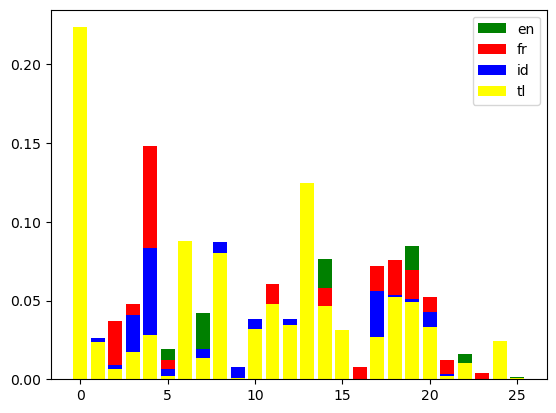

In [135]:
import matplotlib.pyplot as plt
plt.bar(x_train.columns, x_train[0:10].mean(), color = "green", label = "en")
plt.bar(x_train.columns, x_train[10:20].mean(), color = "red", label = "fr")
plt.bar(x_train.columns, x_train[20:30].mean(), color = "blue", label = "id")
plt.bar(x_train.columns, x_train[30:40].mean(),color = "yellow", label = "tl")
plt.legend()
plt.show()

## test 데이터 불러오기

In [59]:
x_test, y_test = count_alphas("test")
x_test = pd.DataFrame(x_test)
x_test, y_test

(          0         1         2         3         4         5         6   \
 0   0.067823  0.013459  0.034328  0.048817  0.116114  0.020014  0.016002   
 1   0.080283  0.016174  0.035350  0.038342  0.129865  0.016704  0.018950   
 2   0.087546  0.014697  0.030850  0.039405  0.121263  0.019975  0.016745   
 3   0.078505  0.012169  0.039091  0.031337  0.119966  0.021215  0.016692   
 4   0.090582  0.012481  0.032243  0.051910  0.137481  0.015980  0.011914   
 5   0.085097  0.010113  0.039651  0.046137  0.139917  0.011880  0.011542   
 6   0.056764  0.012008  0.035835  0.049876  0.127155  0.013476  0.008620   
 7   0.071875  0.011413  0.038476  0.040330  0.139357  0.012185  0.015386   
 8   0.178832  0.026958  0.013194  0.040057  0.092074  0.007119  0.033507   
 9   0.178803  0.036816  0.007309  0.038576  0.080130  0.004467  0.036816   
 10  0.104322  0.022424  0.015275  0.044199  0.089373  0.011375  0.026649   
 11  0.164736  0.026052  0.014586  0.041574  0.088257  0.006201  0.035997   

## 3. 데이터 가공 및 전처리
- 정규화는 위에서 함
- 타겟 -> one-hot encoding

In [60]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(sparse_output=False)
OH_encoder

OneHotEncoder(sparse_output=False)

In [76]:
y_train = np.array(y_train).reshape(len(y_train), -1)
y_test = np.array(y_test).reshape(len(y_test), -1)

In [77]:
OH_encoder.fit(y_train)
y_train = OH_encoder.transform(y_train)
y_test = OH_encoder.transform(y_test)

## 5. 학습

### 5-1 모델 생성

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
Forest_Classifier = RandomForestClassifier()

In [78]:
Forest_Classifier.fit(x_train, y_train)

RandomForestClassifier()

In [80]:
Forest_Classifier.score(x_train, y_train)

1.0

In [81]:
Forest_Classifier.score(x_test, y_test)

1.0

# 예측 진행

In [109]:
def predict_fuction():
    user = input("알파벳을 입력하세요 : ").lower()
    
    ################################
    temp_array = np.zeros(26)
    
    for c in user: # 한 글자씩 읽기
        if c.isalpha(): # A~Z, a~z
            if ord(c) <= 122:
                # print(ord(c)-97, "=>",c)
                temp_array[ord(c)-97] += 1 # 소문자로 변환
    
    temp_array = temp_array/sum(temp_array) # 전처리 정규화
    user_input = temp_array.reshape(-1, len(temp_array))
    return user_input

In [111]:
# en -> 영어
'''
Washington:
The United States warned Russian authorities earlier in March about a terrorist attack possibly targeting "large gatherings" in Moscow, the White House said Friday, hours after a mass shooting killed at least 60 people outside the Russian capital.
"Earlier this month, the US government had information about a planned terrorist attack in Moscow -- potentially targeting large gatherings, to include concerts" and Washington "shared this information with Russian authorities," National Security Council spokeswoman Adrienne Watson said.

Watson said the administration of US President Joe Biden was complying with a long-standing "duty to warn" policy, in which the United States alerts nations or groups when it receives intelligence of specific threats to kidnap or kill multiple victims.

Gunmen opened fire at a Moscow concert hall earlier in the day killing more than 60 people, wounding more than 100 and sparking an inferno, authorities said, with the Islamic State group claiming responsibility.

Listen to the latest songs, only on JioSaavn.com

US officials have told AFP they believe the claim of responsibility by the Islamic State to be credible.

Russia's Investigative Committee said Saturday that more than 60 people had been killed, raising an earlier toll of 40, according to Russian news agencies.

Post a comment
(Except for the headline, this story has not been edited by NDTV staff and is published from a syndicated feed.)
'''
pre_target = Forest_Classifier.predict(predict_fuction())
pre_target
OH_encoder.inverse_transform(pre_target)
# 0 -> en
# 1 -> fr
# 2 -> id
# 3 -> tl
# 입력값 z와 x는 인도의 경우 1회 답은 알 수 없지만 x, z 넣었을 때  확률은 인도가 제일 낮아야함



array([['en']], dtype='<U2')

In [114]:
# fr -> 프랑스어
'''
Une vraie petite araignée
« Dites, monsieur, depuis combien de temps vos jumelles (Oriane et Margot) font-elles de l’escalade ? », demanda un moniteur, étonné par l’aisance de ces jumelles de 7 ans sur un mur d’escalade.
« Ah non, aujourd’hui, c’est leur première fois… », répondit le papa. Immédiatement, le moniteur lui conseilla de les inscrire dans un club.
Aussitôt fait : Oriane et Margot ont commencé à s’entraîner dans le club des Avirons, sur l’île de La Réunion.
Aujourd’hui, Oriane a 19 ans, et elle grimpe comme si elle avait des gènes d’araignée en elle. Une fois ses mains saupoudrées de magnésie (craie) pour mieux adhérer à la paroi (en plein air) ou au mur d’escalade (en salle), plus personne ne l’arrête. Et, depuis ses débuts en poussine, Oriane Bertone a pris le goût du défi : « Dès que je sens la difficulté, je suis excitée. Alors, au lieu d’en avoir peur, ça me donne des ailes… »
Et aujourd’hui, la Française décroche des médailles à chaque compétition.

Une des premières aux Jeux !
En octobre dernier, Oriane Bertone a même été une des toutes premières officiellement sélectionnées pour les Jeux olympiques de Paris. « Dans le milieu, on trouve mon ascension fulgurante, mais moi je me remets en question au pied de chaque paroi. En avoir vaincu une, la veille, n’assure pas une victoire sur une autre, le lendemain. Je dois être hyper-concentrée sur chaque centimètre. »
Paris sera ses premiers Jeux olympiques : « Même si je suis née à Nice et que ma famille vit à La Réunion, je m’entraîne près de Paris, à Fontainebleau. Donc, je serai un peu comme chez moi à Paris… »

« Pas peur de la pression aux Jeux… »
Alors, confiante ou pas pour les Jeux de Paris, Oriane ? « Oui, même si je sais que la pression, à la maison, sera colossale. Mais je n’en ai pas peur… enfin, pour l’instant ! En plus, il risque d’y avoir un public de ouf ! »
'''
pre_target = Forest_Classifier.predict(predict_fuction())
pre_target
OH_encoder.inverse_transform(pre_target)


array([['fr']], dtype='<U2')

In [137]:
# tl -> 필리핀 타갈로그어
'''
ulubulkaning Cordillera de Apaneca sa El Salvador. Tahanan ang bansa sa 170 bulkan, aktibo ang 23 sa mga ito, kabilang dito ang dalawang kaldera, at higbulkan ang isa sa mga ito. Nabigyan ang El Salvador ng taguring La Tierra de Soberbios Volcanes, (Ang Lupa ng mga Kahanga-hangang Bulkan).
Tungkol ito sa isang anyong lupa, para sa mitolohikong diyos, tingnan ang Bulkan (diyos).
Ang bulkan ay pagkalagot sa krast ng isang bagay na may buntalaing laki, tulad ng Daigdig, na nagpapahintulot sa pagbuga ng mainit na lava, abo-bulkan, at buhag mula sa liyaban ng magma sa ilalim ng lupa.

Mayroong mga bulkan sa Daigdig dahil na nakahiwalay ang kanyang krast sa 17 pangunahing, maigting na plakang tektonika na lumulutang sa mas mainit at mas malambot na latag ng mundo.[1] Samakatuwid, sa Daigdig, kadalasang matatagpuan ang mga bulkan kung saan naghihiwalay o nagdidikitan ang mga plakang tektonika, at matatagpuan ang karamihan nito sa ilalim ng tubig. Bilang halimbawa, isang gitkaragatang gulod, tulad ng Git-Atlantikong Gulod, ay mga bulkan na bunga ng mga pahiwalay na plakang tektonika samantalang ang Singsing ng Apoy ng Pasipiko ay may mga bulkan na bunga ng mga nagdidikit na plakang tektonika. Maaari ring mabuo ang mga bulkan kung saan may pagbanat at pagpayat sa mga plaka ng krast, hal. sa Siwang ng Silangang Aprika, sa bulubulkanin ng Wells Gray-Clearwater, at Siwang ng Rio Grande sa Hilagang Amerika. Ang ganitong uri ng bulkanismo ay nasa ilalim ng grupo ng "palagayin ng plaka" sa bulkanismo.[2] Ipinaliwanag din ang bulkanismo na malayo sa mga hangganan ng plaka bilang mga pluma ng latag. Ipinapalagay na ang mga tinatawag na "batik-init", tulad ng Hawaii, ay nanggagaling mula sa tumataas na diapir na may magma mula sa hangganan ng ubod–latag, 3,000 km kalalim sa Daigdig. Hindi naman nabubuo ang mga bulkan sa pagdulas ng dalawang plato sa isa't isa.

Maaaring magdulot ang mga pumuputok na bulkan ng mararaming panganib, hindi lamang sa paligid ng pagputok. Isang halimbawa ng peligro ay maaaring maging panganib ang abo sa mga eroplano, lalo na ang mga mayroong mga likhisog panghimpapawid kung saan natutunaw ang mga tipik ng abo sa mataas na temperatura ng pagpapatakbo; pagkatapos, dumidikit ang mga natunaw na tipik sa mga talim ng turbina at nagbabago sa hugis nito na nakaiistorbo sa pagtakbo ng turbina. Nakaaapekto ang mga malaking pagsabog sa temperatura dahil hinaharangan ng abo at mga patak ng mga asido sulpuriko ang araw at nagpapalamig sa ibabang atmospera (o himpapawid); gayunman, maaari rin silang mabaon ng init na siningaw ng Daigdig, sa gayon ay nagpapainit sa mas itaas na atmospera (o alangaang). Ayon sa kasaysayan, naging sanhi ang mga bulkanikong tagginaw ng mga napakamalalang taggutom.

Etimolohiya

Bulkang Cleveland sa Kapuluang Aleutiano ng Alaska na kinuha mula sa Pandaigdigang Himpilang Pangkalawakan, Mayo 2006

Mapa na nagpapakita ng mga hangganang pahiwalay (naghihiwalay na oseanikong gulod at kamakailang kubhangining bulkan)
Nanggaling ang salitang bulkan mula sa pangalan ng Vulcano, isang bulkanikong pulo sa Kapuluang Eoliko ng Italya na ang pangalan naman ay nanggaling mula kay Vulcan, ang diyos ng apoy sa mitolohiyang Romano.[3] Ang pag-aaral sa mga bulkan ay tinatawag na bulkanolohiya.

Plakang Tektonika
Pangunahing artikulo: Tektonika ng plaka
Hangganang pahiwalay
'''
pre_target = Forest_Classifier.predict(predict_fuction())
pre_target
OH_encoder.inverse_transform(pre_target)

array([['tl']], dtype='<U2')